# Final Project

## Introduction

In the following development we will tend to reproduce numeralically the results published by Sussillo and Abbott onto their papers: 'Generating Coherent Patterns of Activity from Chaotic Neural Networks'.
In order to stuck to easily reproducable and understandable results, our results we be based on a complete coding of the learning algorithm avoiding the use of any previously coded librairies. 



## Paper abstract reminder

Neural circuits display complex activity patterns both spontaneously and when responding to a stimulus or generating a motor output. How are these two forms of activity related? We develop a procedure called FORCE learning for modifying synaptic strengths either external to or within a model neural network to change chaotic spontaneous activity into a wide variety of desired activity patterns. FORCE learning works even though the networks we train are spontaneously chaotic and we leave feedback loops intact and unclamped during learning. Using this approach, we construct networks that produce a wide variety of complex output patterns, input-output transformations that require memory, multiple outputs that can be switched by control inputs, and motor patterns matching human motion capture data. Our results reproduce data on premovement activity in motor and premotor cortex, and suggest that synaptic plasticity may be a more rapid and powerful modulator of network activity than generally appreciated.


## Results - (Sussillo and Abbott figure 2 reproduction)

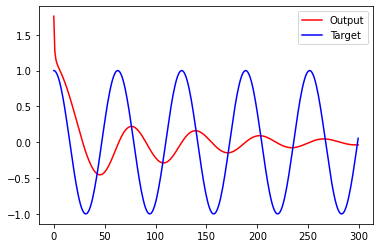

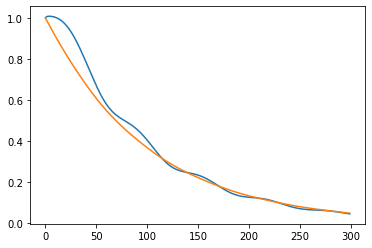

In [1]:


""" Notes : attention au décalage de phase (d'un indice) entre la fonction f et la réponse z
Pourquoi mon amplitude diminue-t-elle ?
Pourquoi définit-on P alors que ça va être t.Id pendant tout le déroulé de l'algorithme ? """

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10645)

N_G = 3 ### mauvaise valeur
g_GG = 1
p_GG = 0.1
p_z = 1
g_Gz = 1
g_GF = 0
alpha = 1
N_l = 0
tau = 10

def define_initial_weights(N_G, p_z):   
    w_init = np.zeros(N_G)
    for k in range(N_G):
        p = np.random.uniform(0, 1, 1)
        if p <= p_z:
            w_init[k] = np.random.normal(0, 1/(p_z*N_G), 1)

    return w_init


def define_connection_matrix_J(N, proba):
    J = np.array([np.zeros(N) for j in range(N)])
    for i in range(N):
        for j in range(N):
            p = np.random.uniform(0, 1, 1)
            if p  <= proba:
                J[i][j] = np.random.normal(0, 1/(proba*N), 1)

    return J

def update_x_t_by_euler_method(x, r, z, dt, tau, N_G, g_GG, J_GG, g_Gz, J_Gz):
    """ This function computes x(t+dt) knowing x(t) for every i
    This holds for Figure 2 and a simpler version of the differential equation
    x_in, r_in and z are functions of t ; tau, N_G, g_GG, J_GG, g_Gz and J_Gz are constants"""
    
    x_out = []
    
    for i in range(N_G):
        variation = -x[i] + g_GG * np.dot(J_GG[i], r) + g_Gz * J_Gz[i] * z
        variation = variation / tau
        x_out.append(x[i] + variation * dt)
    
    return np.array(x_out)


def compute_z(w, r):
    """ w and r as numpy arrays of same size. They are the weights and the 
    firing rates at time t. The function returns the dot
    product of the two, which is the output of the network)"""
    return np.dot(w, r)

def compute_error(w_delta, r, f):
    """ The function returns the error (scalar)"""
    return np.dot(w, r) - f

def check_decreasing_error(e_minus, e_plus):
    if abs(e_plus) <= abs(e_minus):
        return True
    return False

def modification_rule_weights(w, e_minus, P, r):
    """ w, e_minus and r are column arrays, P is a matrix 
    w is taken at time t - Delta_t ; the others at time t """
    w = w - e_minus * np.dot(P, r)
    return w

def modification_rule_matrix(P, r):
    """ P is a matrix, taken at time t - Delta_t
    r is the synaptic array taken at time t """
    D = np.outer(r, r)
    D = np.dot(D, P)
    D = np.dot(P, D)
    Pr = np.dot(P, r)
    a = np.dot(r, Pr)
    return P - D/(1 +a)


delta_t = 0.01
J_GG = define_connection_matrix_J(N_G, p_GG)
J_Gz = np.random.uniform(0, 1, N_G)

list_outputs = []
list_target_values = []
list_ratio_errors = []
list_difference_errors_plus = []
liste_x_1 = []
liste_x_0 = []

# Define initial variables
P = np.eye(N_G)/alpha
w = define_initial_weights(N_G, p_z)
x = np.ones(N_G)


nb_etapes = 300

# Before updating the weigths
"""
for t in range(int(nb_etapes/20)):
    liste_x_1.append(x[1])
    liste_x_0.append(x[0])
    r = np.tanh(x)
    z = compute_z(w, r)
    x = update_x_t_by_euler_method(x, r, z, 1/10, tau, N_G, g_GG, J_GG, g_Gz, J_Gz)
    list_outputs.append(z)
"""


for t in range(nb_etapes):    
    liste_x_1.append(x[1])
    liste_x_0.append(x[0])
    f = np.cos(t/10)
    r = np.tanh(x)
    z = compute_z(w, r) # = w(t - delta_t) * r(t)
    e_minus = compute_error(w, r, f)
    
    w = modification_rule_weights(w, e_minus, P, r)
    P = modification_rule_matrix(P, r)
    
    e_plus = compute_error(w, r, f)
    
    if check_decreasing_error(e_minus, e_plus) == False:
        print(t)
        #break
    
    z = compute_z(w,r)
    x = update_x_t_by_euler_method(x, r, z, 1/10, tau, N_G, g_GG, J_GG, g_Gz, J_Gz)
    
    list_outputs.append(z)
    list_target_values.append(f)
    list_ratio_errors.append(e_plus/e_minus)
    list_difference_errors_plus.append(e_plus)

#abscisses = [t/10 for t in range(int(21/20*nb_etapes))]
plt.plot(list_outputs, color = 'red', label = 'Output')
plt.plot(list_target_values, color = 'blue', label = 'Target')
plt.legend()
plt.show()


# Plot the activity of two specific neurons

plt.plot(liste_x_1) # C'est instructif
plt.plot(liste_x_0)
plt.show()

In [ ]:
## Examples of FORCE Learning (Sussillo and Abbott figure 3 reproduction)